In [1]:
import numpy as np
import sys
import cv2 as cv
import tqdm

from PIL import Image
from IPython.display import display

In [2]:
# using algorithm in 3.2 apply image gradients as computed in eq2:
# G(x,y) = ||I(x+1,y) - I(x-1,y)||^2+ ||I(x,y+1) - I(x,y-1)||^2

In [3]:
def generate_pixels():
    indnp = np.mgrid[0:SLIC_height,0:SLIC_width].swapaxes(0,2).swapaxes(0,1)
    for i in tqdm.tqdm(range(SLIC_ITERATIONS)):
        SLIC_distances = 1 * np.ones(img.shape[:2])
        for j in range(SLIC_centers.shape[0]):
            x_low, x_high = int(SLIC_centers[j][3] - step), int(SLIC_centers[j][3] + step)
            y_low, y_high = int(SLIC_centers[j][4] - step), int(SLIC_centers[j][4] + step)

            if x_low <= 0:
                x_low = 0
            #end
            if x_high > SLIC_width:
                x_high = SLIC_width
            #end
            if y_low <=0:
                y_low = 0
            #end
            if y_high > SLIC_height:
                y_high = SLIC_height
            #end

            cropimg = SLIC_labimg[y_low : y_high , x_low : x_high]
            color_diff = cropimg - SLIC_labimg[int(SLIC_centers[j][4]), int(SLIC_centers[j][3])]
            color_distance = np.sqrt(np.sum(np.square(color_diff), axis=2))

            yy, xx = np.ogrid[y_low : y_high, x_low : x_high]
            pixdist = ((yy-SLIC_centers[j][4])**2 + (xx-SLIC_centers[j][3])**2)**0.5

            # SLIC_m is "m" in the paper, (m/S)*dxy
            dist = ((color_distance/SLIC_m)**2 + (pixdist/step)**2)**0.5

            distance_crop = SLIC_distances[y_low : y_high, x_low : x_high]
            idx = dist < distance_crop
            distance_crop[idx] = dist[idx]
            SLIC_distances[y_low : y_high, x_low : x_high] = distance_crop
            SLIC_clusters[y_low : y_high, x_low : x_high][idx] = j
        #end

        for k in range(len(SLIC_centers)):
            idx = (SLIC_clusters == k)
            colornp = SLIC_labimg[idx]
            distnp = indnp[idx]
            SLIC_centers[k][0:3] = np.sum(colornp, axis=0)
            sumy, sumx = np.sum(distnp, axis=0)
            SLIC_centers[k][3:] = sumx, sumy
            SLIC_centers[k] /= np.sum(idx)
        #end
    #end
#end

# At the end of the process, some stray labels may remain meaning some pixels
# may end up having the same label as a larger pixel but not be connected to it
# In the SLIC paper, it notes that these cases are rare, however this 
# implementation seems to have a lot of strays depending on the inputs given

def create_connectivity():
    label = 0
    adj_label = 0
    lims = int(SLIC_width * SLIC_height / SLIC_centers.shape[0])
    
    new_clusters = -1 * np.ones(img.shape[:2]).astype(np.int64)
    elements = []
    for i in range(SLIC_width):
        for j in range(SLIC_height):
            if new_clusters[j, i] == -1:
                elements = []
                elements.append((j, i))
                for dx, dy in [(-1,0), (0,-1), (1,0), (0,1)]:
                    x = elements[0][1] + dx
                    y = elements[0][0] + dy
                    if (x>=0 and x < SLIC_width and 
                        y>=0 and y < SLIC_height and 
                        new_clusters[y, x] >=0):
                        adj_label = new_clusters[y, x]
                    #end
                #end
            #end

            count = 1
            counter = 0
            while counter < count:
                for dx, dy in [(-1,0), (0,-1), (1,0), (0,1)]:
                    x = elements[counter][1] + dx
                    y = elements[counter][0] + dy

                    if (x>=0 and x<SLIC_width and y>=0 and y<SLIC_height):
                        if new_clusters[y, x] == -1 and SLIC_clusters[j, i] == SLIC_clusters[y, x]:
                            elements.append((y, x))
                            new_clusters[y, x] = label
                            count+=1
                        #end
                    #end
                #end

                counter+=1
            #end
            if (count <= lims >> 2):
                for counter in range(count):
                    new_clusters[elements[counter]] = adj_label
                #end

                label-=1
            #end

            label+=1
        #end
    #end

    SLIC_new_clusters = new_clusters
#end

def display_contours(color):
    is_taken = np.zeros(img.shape[:2], np.bool)
    contours = []

    for i in range(SLIC_width):
        for j in range(SLIC_height):
            nr_p = 0
            for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1)]:
                x = i + dx
                y = j + dy
                if x>=0 and x < SLIC_width and y>=0 and y < SLIC_height:
                    if is_taken[y, x] == False and SLIC_clusters[j, i] != SLIC_clusters[y, x]:
                        nr_p += 1
                    #end
                #end
            #end

            if nr_p >= 2:
                is_taken[j, i] = True
                contours.append([j, i])
            #end
        #end
    #end
    for i in range(len(contours)):
        img[contours[i][0], contours[i][1]] = color
    #end
#end

def find_local_minimum(center):
    min_grad = 1
    loc_min = center
    for i in range(center[0] - 1, center[0] + 2):
        for j in range(center[1] - 1, center[1] + 2):
            c1 = SLIC_labimg[j+1, i]
            c2 = SLIC_labimg[j, i+1]
            c3 = SLIC_labimg[j, i]
            if ((c1[0] - c3[0])**2)**0.5 + ((c2[0] - c3[0])**2)**0.5 < min_grad:
                min_grad = abs(c1[0] - c3[0]) + abs(c2[0] - c3[0])
                loc_min = [i, j]
            #end
        #end
    #end
    return loc_min
#end

def calculate_centers():
    centers = []
    for i in range(step, SLIC_width - int(step/2), step):
        for j in range(step, SLIC_height - int(step/2), step):
            nc = find_local_minimum(center=(i, j))
            color = SLIC_labimg[nc[1], nc[0]]
            center = [color[0], color[1], color[2], nc[0], nc[1]]
            centers.append(center)
        #end
    #end

    return centers
#end

100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


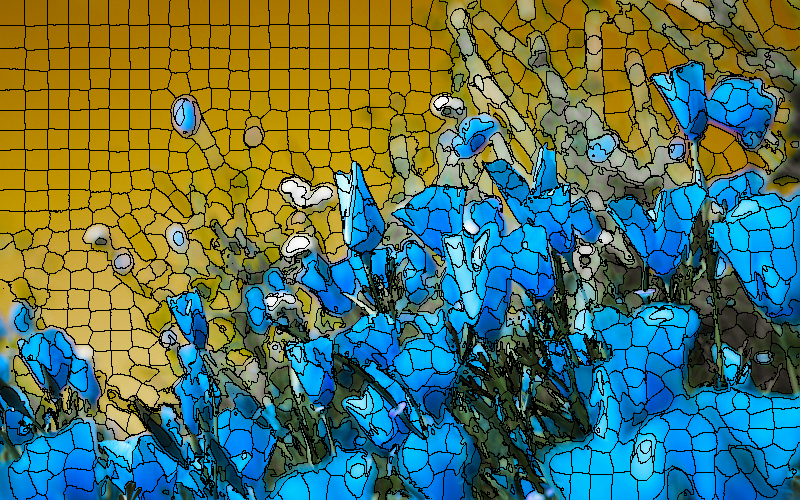

True

In [5]:
# global variables
img = cv.imread('data/flower.jpg')

imgsize = img.shape[:2]
img_width  = imgsize[1]
img_height = imgsize[0]

# Chọn step = 1000
step = int((img_height*img_width/int(1000))**0.5)

# Chọn slic m = 40
SLIC_m = int(40)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float64)
SLIC_distances = 1 * np.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = np.zeros(len(calculate_centers()))
SLIC_centers = np.array(calculate_centers())


generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])

display(Image.fromarray(img))
cv.imwrite('edf.jpg', img) 